# Sieci Neuronowe, PWR 2023
## Klasyfikacja roślin na podstawie zdjęć za pomocą sieci neuronowych
Autorzy:
- Dominik Ćwikowski 248914
- Paweł Pelar 243480  

Repozytorium:  
- https://github.com/F3mte/P-Sieci-Neuronowe

Zbiór danych:  
- https://www.kaggle.com/datasets/marquis03/plants-classification

In [11]:
# Import bibliotek i funkcji
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [12]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [13]:
# Określ ścieżki do folderów z plikami 
test_dir = "test"
train_dir = "train"
val_dir = "val"

In [20]:
# Generator dla danych treningowych
train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen_augmented = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=180,
                                   fill_mode='reflect')
train_datagen_augmented2 = ImageDataGenerator(
                                    rescale=1./255,
                                    width_shift_range=0.1,  # Reduced shift range
                                    height_shift_range=0.1,  # Reduced shift range
                                    zoom_range=0.1,  # Reduced zoom range
                                    horizontal_flip=True,
                                    vertical_flip=True,  # Added vertical flip
                                    rotation_range=90,  # Reduced rotation range
                                    shear_range=0.2,  # Added shear range
                                    brightness_range=[0.8, 1.2],  # Added brightness range
                                    fill_mode='nearest'  # Changed fill mode
                                )

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))
train_generator_aug = train_datagen_augmented.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(224, 224)
                                                    )
train_generator_aug2 = train_datagen_augmented2.flow_from_directory(directory=train_dir,
                                                    class_mode='categorical',
                                                    target_size=(224, 224)
                                                    )

Found 21000 images belonging to 30 classes.
Found 21000 images belonging to 30 classes.
Found 21000 images belonging to 30 classes.


In [40]:
# Generator dla danych testowych
test_datagen = ImageDataGenerator(rescale=1./255,)
test_generator = test_datagen.flow_from_directory(directory=test_dir,
                                                  class_mode='categorical',
                                                  target_size=(224, 224),
                                                  shuffle=False)

Found 6000 images belonging to 30 classes.


In [16]:
# Generator dla danych walidacyjnych
validation_datagen = ImageDataGenerator(rescale=1./255,)
validation_generator = validation_datagen.flow_from_directory(directory=val_dir,
                                                              class_mode = 'categorical',
                                                              target_size=(224, 224))

Found 3000 images belonging to 30 classes.


(1, 32, 224, 224, 3)
(32, 224, 224, 3)


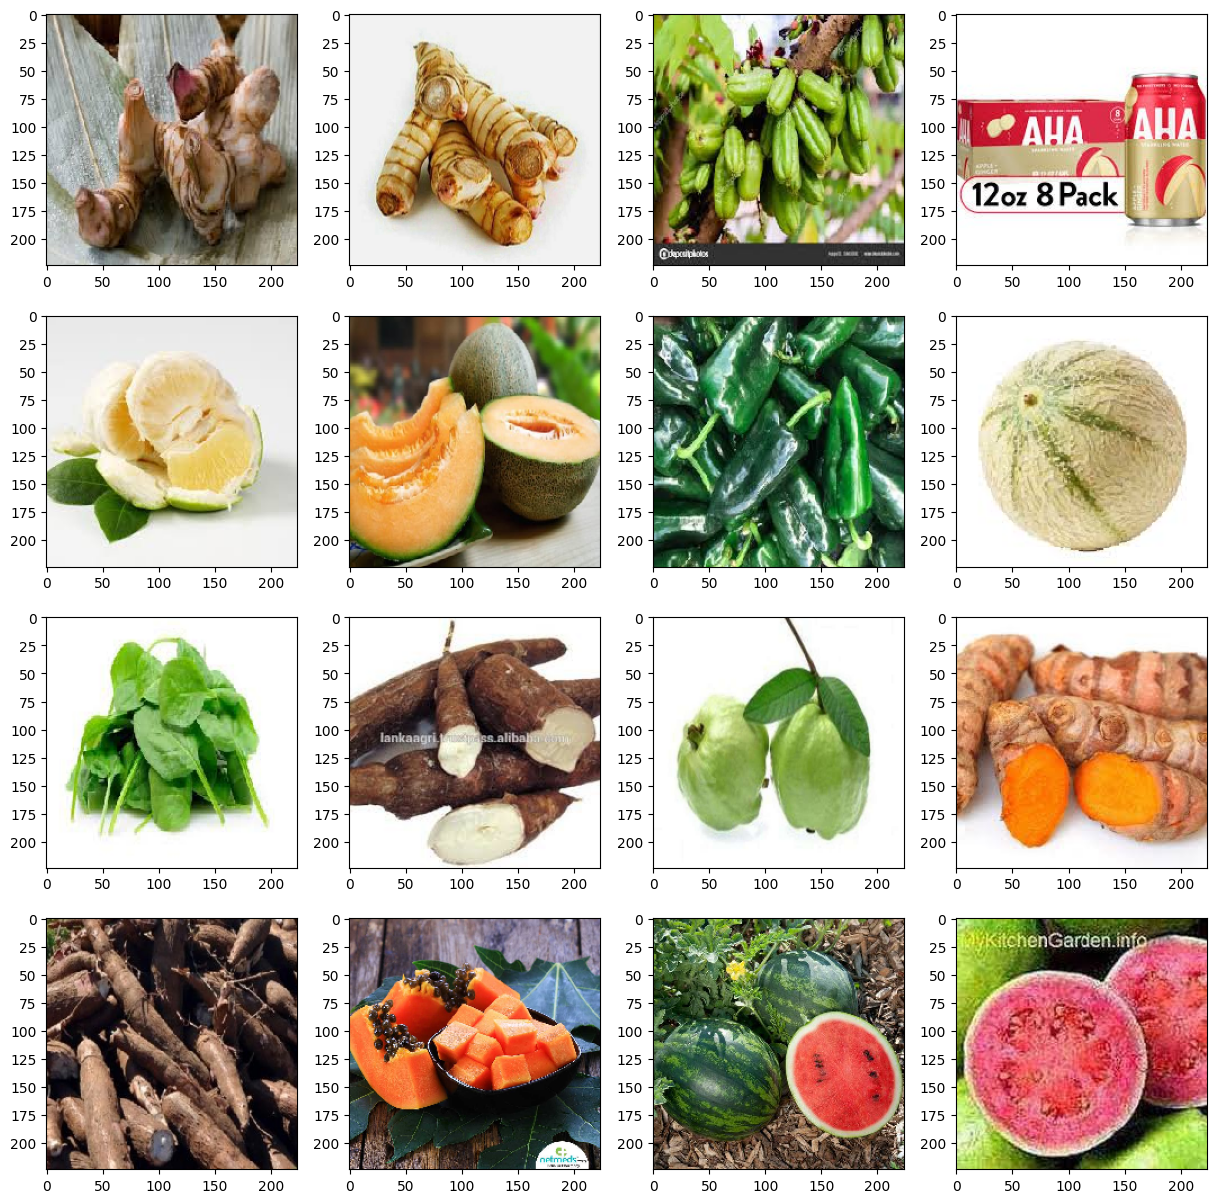

In [18]:
x_train = []
c = 0
for feature, label in train_generator:
    x_train.append(np.array(feature))
    c += 1
    if c == 1:
        break

x_train = np.array(x_train)
print(x_train.shape)
x_train = np.reshape(x_train, (32, 224, 224, 3))
print(x_train.shape)

fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for i in range(0, 16):
    ax[int(i / 4), (i % 4)].imshow(x_train[i])

# Proponowana architektura

Input 224x224x3  

Conv2D 64, 3x3, relu  
MaxPooling 2x2  

Conv2D 64, 3x3, relu  
MaxPooling 2x2  

Conv2D 64, 3x3, relu  
MaxPooling 2x2  

Flatten  
Dropout (0.2 - 0.5)  

Dense 128, relu  
Dropout (0.2 - 0.5) 

Dense 30, softmax  

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

def create_model_v1(activation_function, filters_list, dense_number, dropout_list):
    # Definiowanie modelu z podaną architekturą
    model = Sequential([
        # Warstwa wejściowa: Input 224x224x3 jest domyślnie określona przez target_size w generatorze
        # Pierwsza warstwa konwolucyjna
        Conv2D(filters_list[0], (3, 3), activation=activation_function, input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        # Druga warstwa konwolucyjna
        Conv2D(filters_list[1], (3, 3), activation=activation_function),
        MaxPooling2D(2, 2),

        # Trzecia warstwa konwolucyjna
        Conv2D(filters_list[2], (3, 3), activation=activation_function),
        MaxPooling2D(2, 2),

        # Spłaszczanie danych do jednowymiarowej tablicy
        Flatten(),

        # Dropout (0.2 - 0.5 lub brak), użyjemy średniej wartości 0.35
        Dropout(dropout_list[0]),

        # Pierwsza warstwa gęsta
        Dense(dense_number, activation=activation_function),
        Dropout(dropout_list[0]),

        # Warstwa wyjściowa
        Dense(30, activation='softmax')
    ])
    return model

def create_model_v2(activation_function, filters_list, dense_number, dropout_list):
    # Definiowanie modelu z podaną architekturą
    model = Sequential([
        # Warstwa wejściowa: Input 224x224x3 jest domyślnie określona przez target_size w generatorze
        # Pierwsza warstwa konwolucyjna
        Conv2D(filters_list[0], (3, 3), activation=activation_function, input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        # Druga warstwa konwolucyjna
        Conv2D(filters_list[1], (3, 3), activation=activation_function),
        MaxPooling2D(2, 2),

        # Spłaszczanie danych do jednowymiarowej tablicy
        Flatten(),

        # Dropout (0.2 - 0.5 lub brak), użyjemy średniej wartości 0.35
        Dropout(dropout_list[0]),

        # Pierwsza warstwa gęsta
        Dense(dense_number, activation=activation_function),
        Dropout(dropout_list[0]),

        # Warstwa wyjściowa
        Dense(30, activation='softmax')
    ])
    return model

In [8]:
def plot_accuracies(history):
    acc=history.history['accuracy']
    val_acc=history.history['val_accuracy']
    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs=range(len(acc)) # Get number of epochs

    plt.plot(epochs, acc, 'r')
    plt.plot(epochs, val_acc, 'b')
    plt.title('Training and testing accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(['Training', 'testing'])
    plt.show()
    print("")

    plt.plot(epochs, loss, 'r')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and testing loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(['Training', 'testing'])
    plt.show()

# Trenowanie modeli

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 26, 26, 64)      

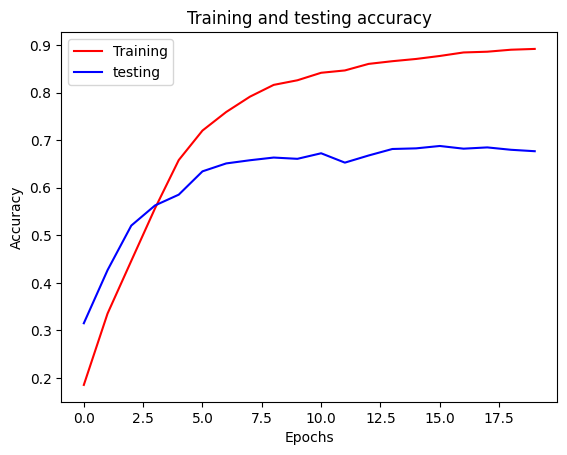

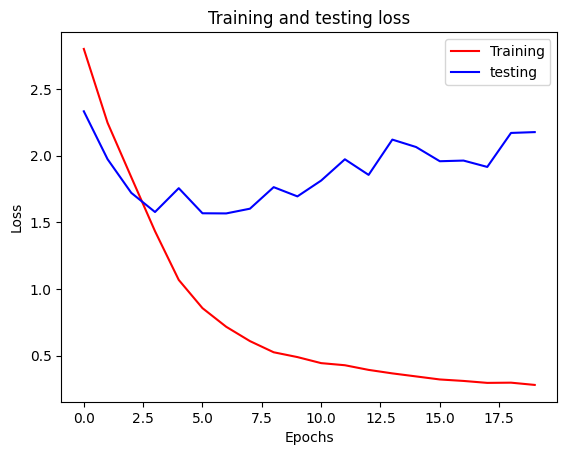

In [13]:
# Dane modelu #1
model_name = 'best_model_nr1'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 26, 26, 64)      

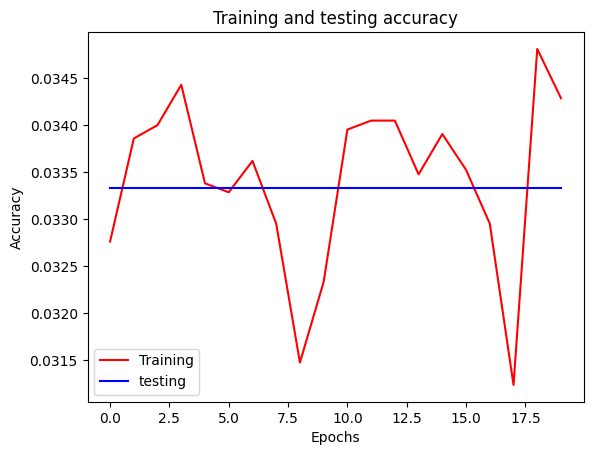

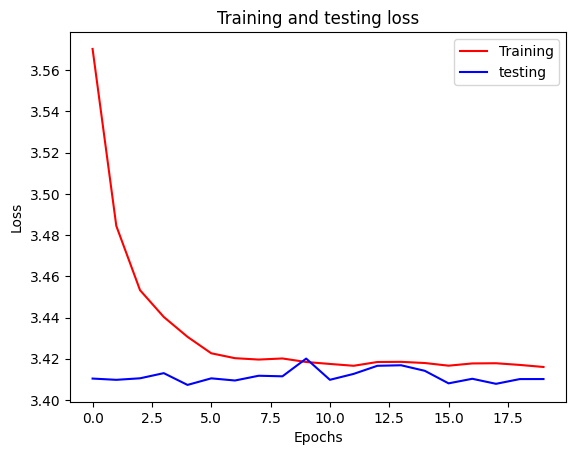

In [14]:
# Dane modelu #2 aktywacja sigmoid
model_name = 'best_model_nr2'
activation_function = 'sigmoid'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 26, 26, 64)      

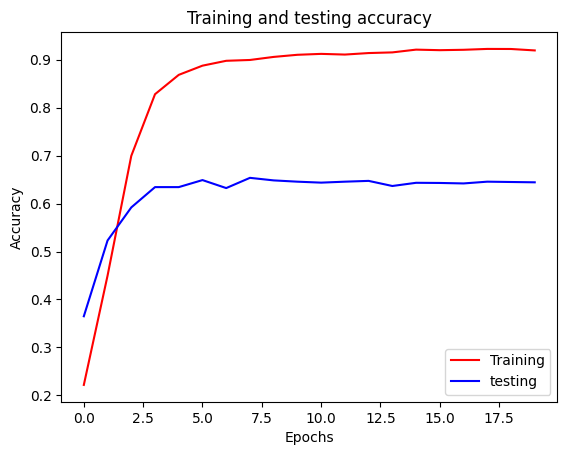

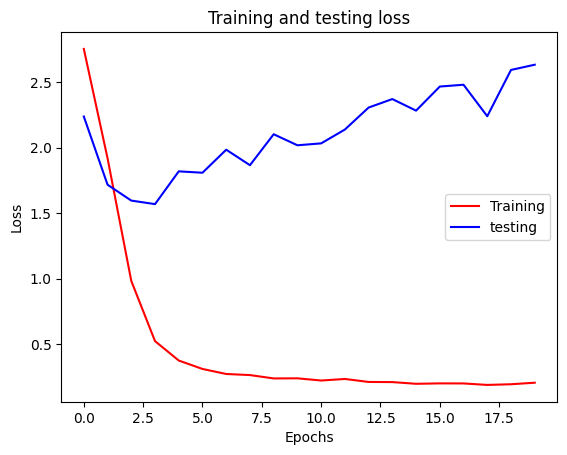

In [15]:
# Dane modelu #3 aktywacja gelu
model_name = 'best_model_nr3'
activation_function = 'gelu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 26, 26, 64)      

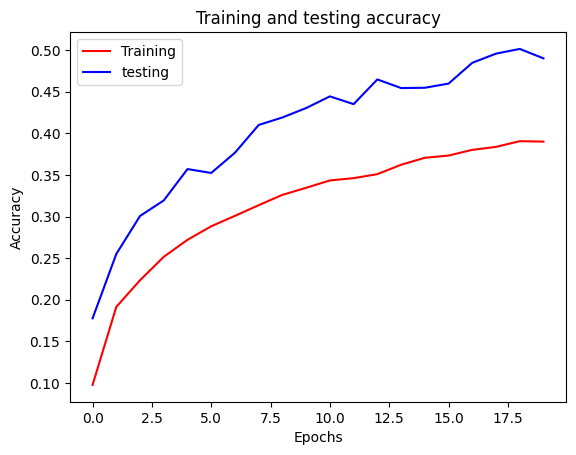

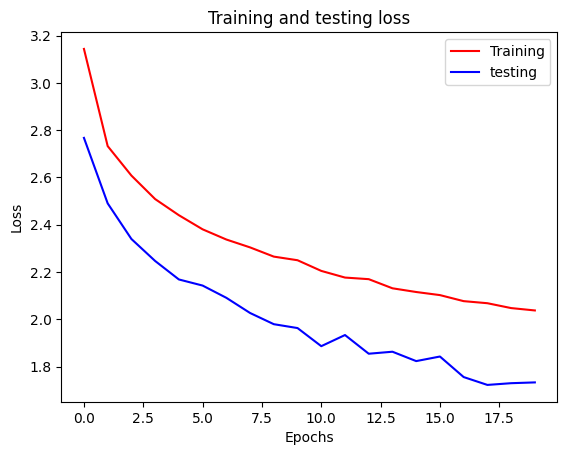

In [16]:
# Dane modelu #4 augmentacja
model_name = 'best_model_nr4'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 26, 26, 64)      

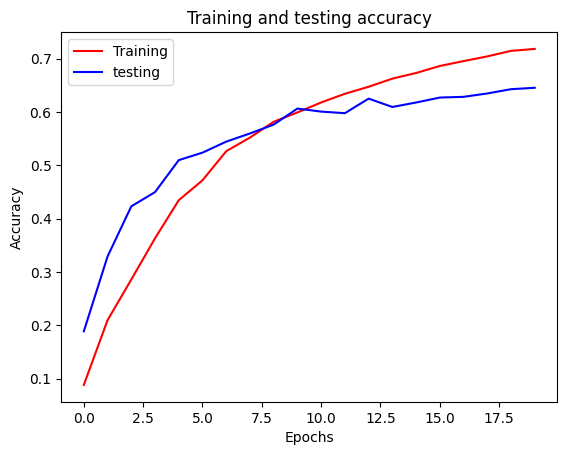

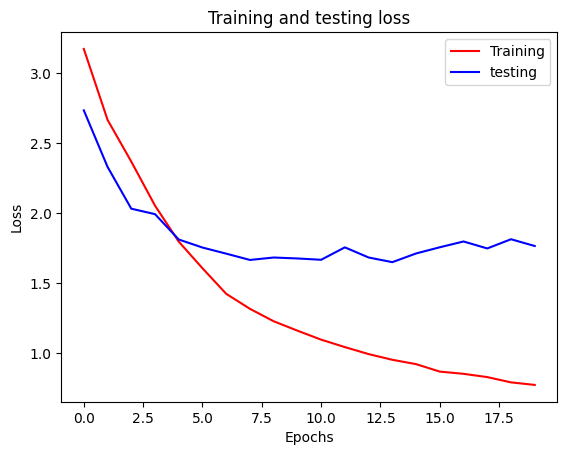

In [17]:
# Dane modelu #5 mniejsza warstwa wyjściowa
model_name = 'best_model_nr5'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 64
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 26, 26, 64)      

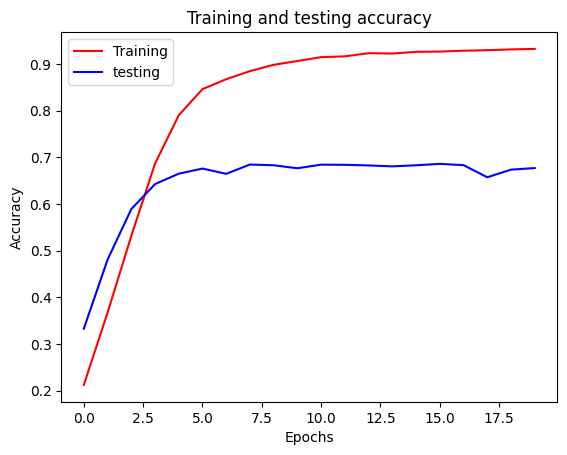

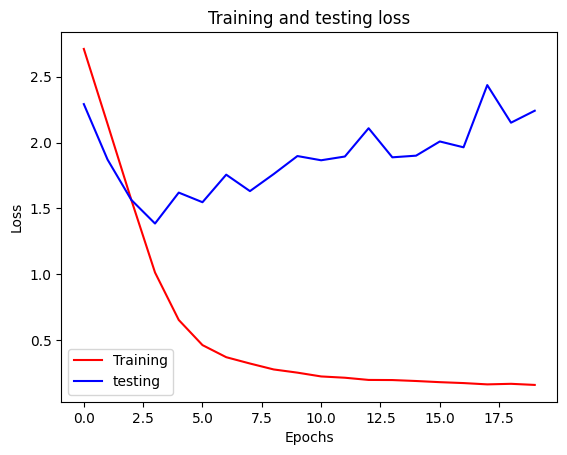

In [18]:
# Dane modelu #6 większa warstwa wyjściowa
model_name = 'best_model_nr6'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 256
dropout_list = [0.35, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 26, 26, 64)      

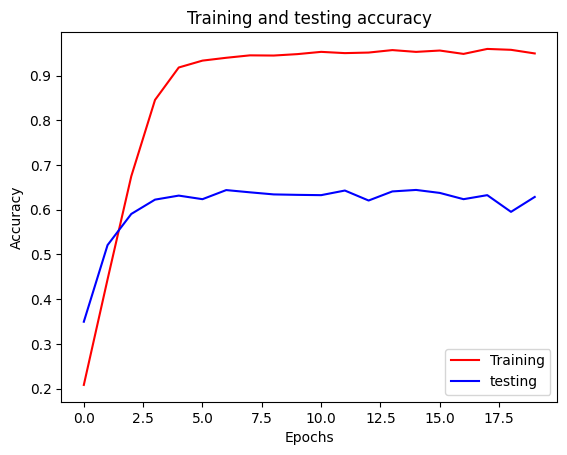

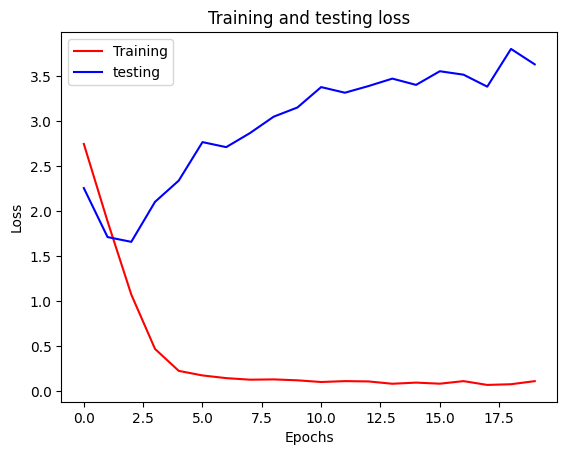

In [19]:
# Dane modelu #7 bez pierwszego dropouta
model_name = 'best_model_nr7'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0, 0.35]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 26, 26, 64)     

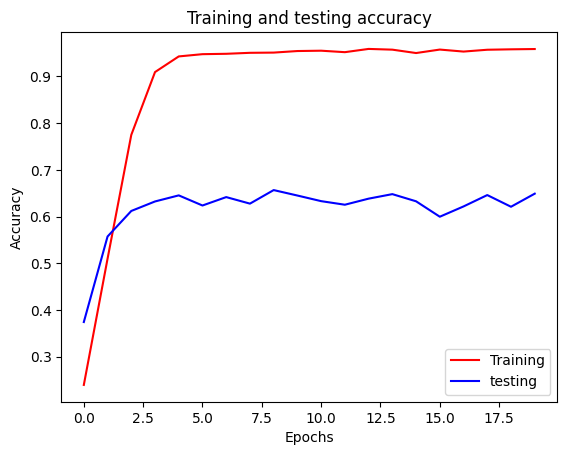

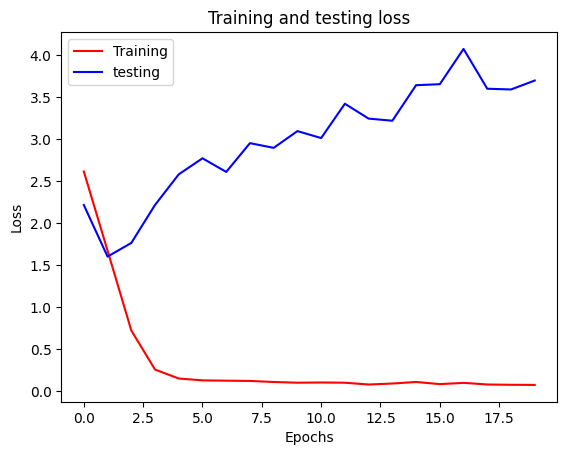

In [20]:
# Dane modelu #8 bez pierwszego dropouta, mniejszy dropout 0.2
model_name = 'best_model_nr8'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0, 0.2]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 26, 26, 64)     

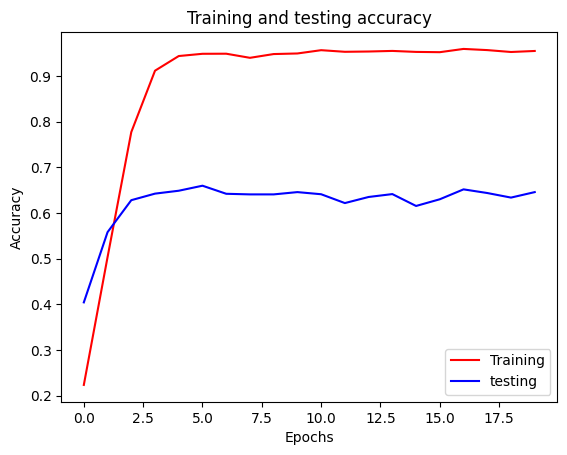

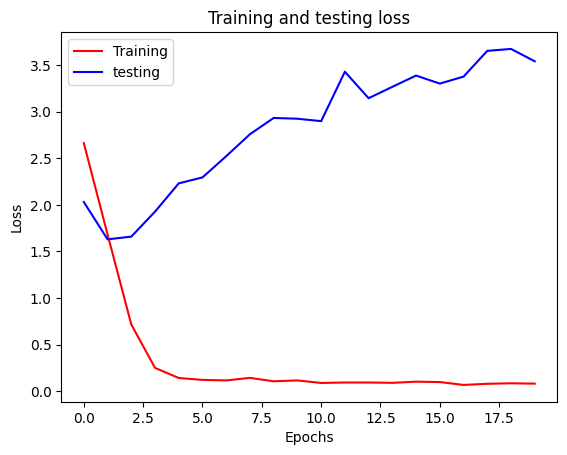

In [21]:
# Dane modelu #9 bez pierwszego dropouta, większy dropout 0.5
model_name = 'best_model_nr9'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 26, 26, 64)     

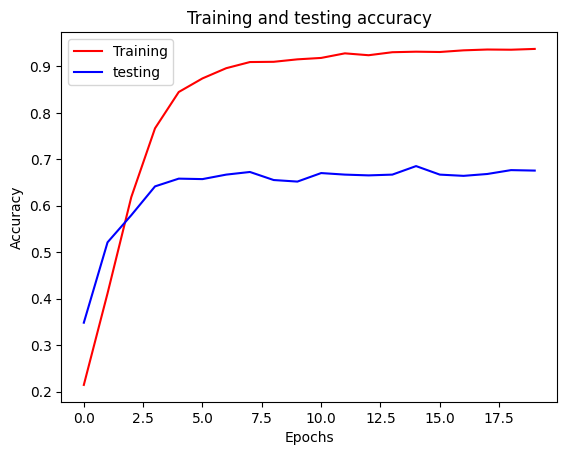

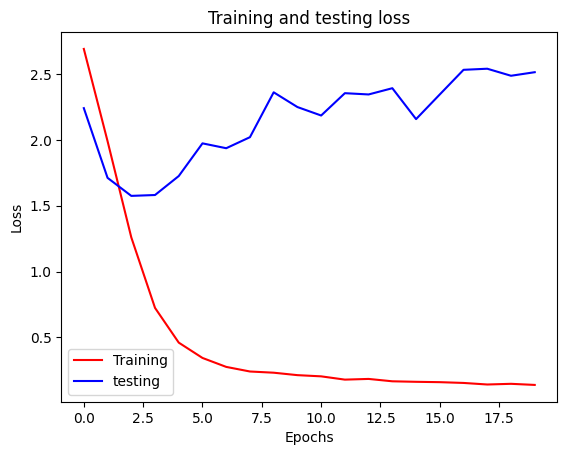

In [22]:
# Dane modelu #10 mniejszy dropout 0.2
model_name = 'best_model_nr10'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.2, 0.2]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 26, 26, 64)     

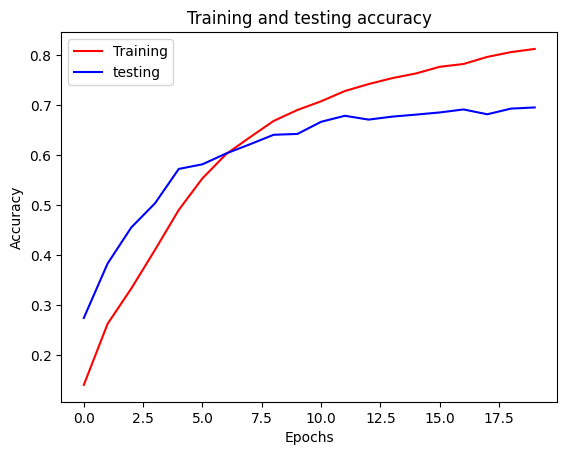

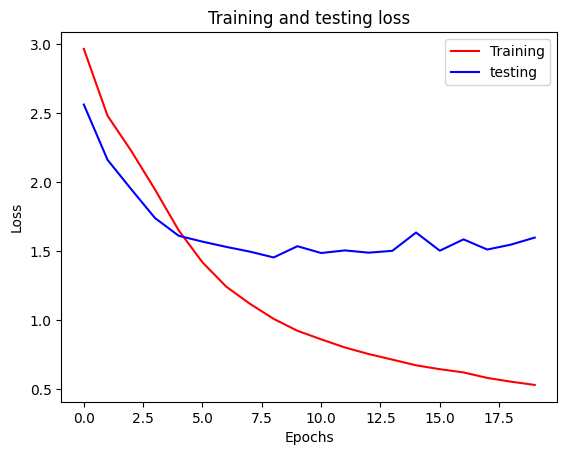

In [23]:
# Dane modelu #11 większy dropout 0.5
model_name = 'best_model_nr11'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 128)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

2024-01-10 21:12:41.191012: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.191080: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.191097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.447632: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-10 21:12:41.447676: I external/local_xla/xla/stream_executor

Epoch 1/20


2024-01-10 21:12:42.729279: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-10 21:12:42.967536: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 21:12:44.237357: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-10 21:12:44.667823: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efa4cd1feb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-10 21:12:44.667851: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-01-10 21:12:44.678778: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1704917564.772709    1084 device_compiler.

657/657 [==============================] - ETA: 0s - loss: 3.4143 - accuracy: 0.0311

/home/pawel/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 115s 162ms/step - loss: 3.4143 - accuracy: 0.0311 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 2/20
657/657 [==============================] - 86s 130ms/step - loss: 3.4020 - accuracy: 0.0317 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 3/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4017 - accuracy: 0.0312 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 4/20
657/657 [==============================] - 86s 131ms/step - loss: 3.4017 - accuracy: 0.0317 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 5/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4017 - accuracy: 0.0321 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 6/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4016 - accuracy: 0.0314 - val_loss: 3.4012 - val_accuracy: 0.0333
Epoch 7/20
657/657 [==============================] - 85s 129ms/step - loss: 3.4016 - accuracy: 0.0319 - val_loss: 3.4012 - val_accuracy: 0.

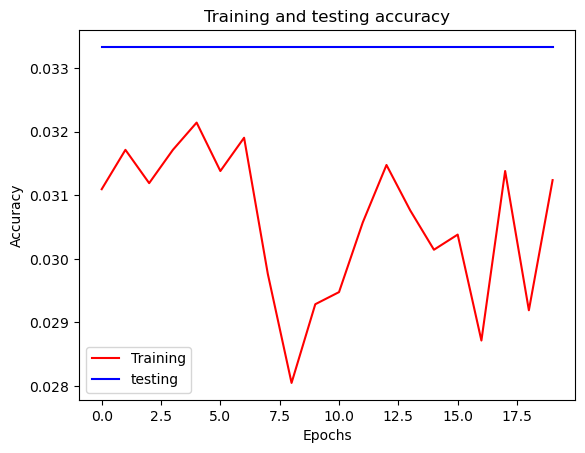

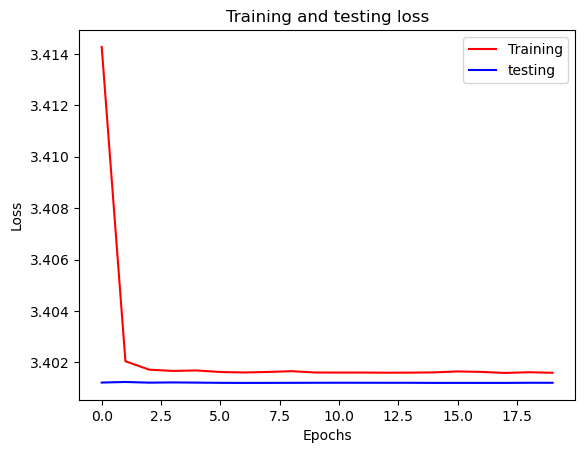

In [9]:
# Dane modelu #12 więcej filtrów
model_name = 'best_model_nr12'
activation_function = 'relu'
filters_list = [128, 128, 128]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_15 (Flatten)        (None, 186624)            0         
                                                                 
 dropout_30 (Dropout)        (None, 186624)          

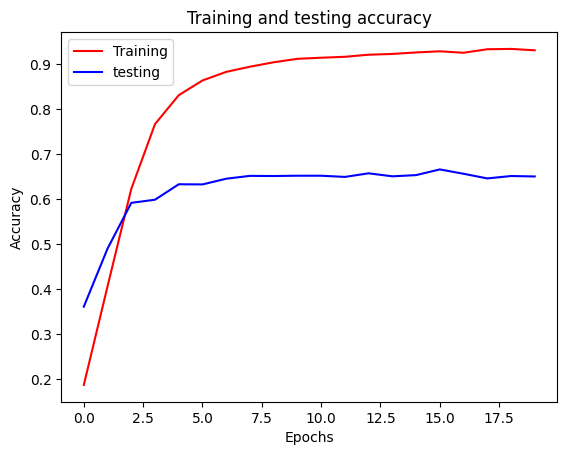

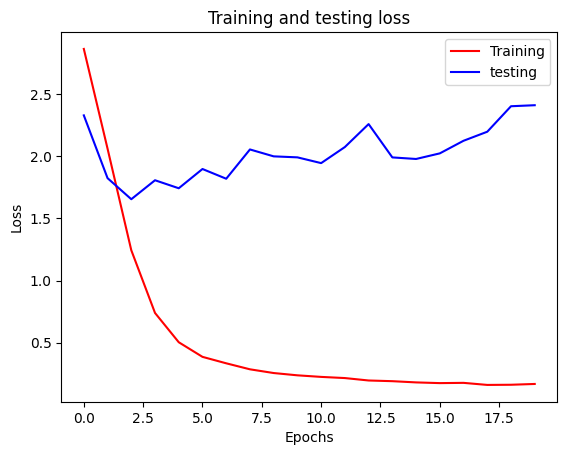

In [26]:
# Dane modelu #13 
model_name = 'best_model_nr13'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 111, 111, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 186624)            0         
                                                                 
 dropout_32 (Dropout)        (None, 186624)          

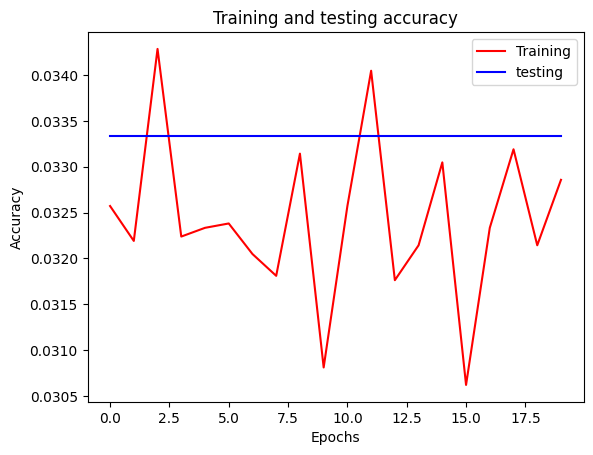

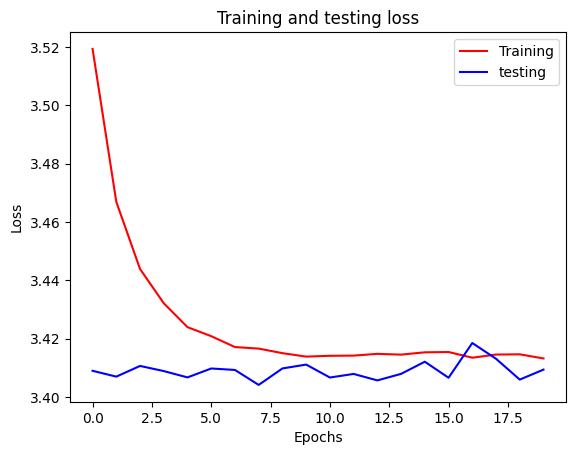

In [27]:
# Dane modelu #14 aktywacja sigmoid
model_name = 'best_model_nr14'
activation_function = 'sigmoid'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 186624)            0         
                                                                 
 dropout_2 (Dropout)         (None, 186624)           

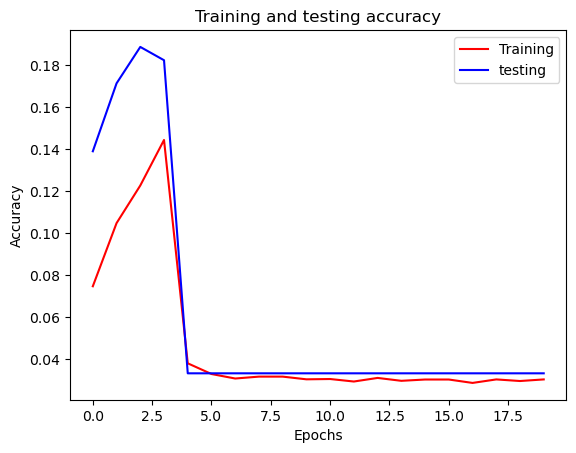

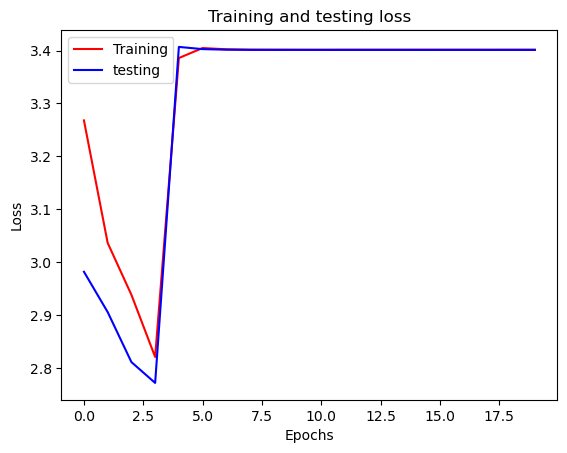

In [10]:
# Dane modelu #15 aktywacja gelu
model_name = 'best_model_nr15'
activation_function = 'gelu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 186624)            0         
                                                                 
 dropout_4 (Dropout)         (None, 186624)           

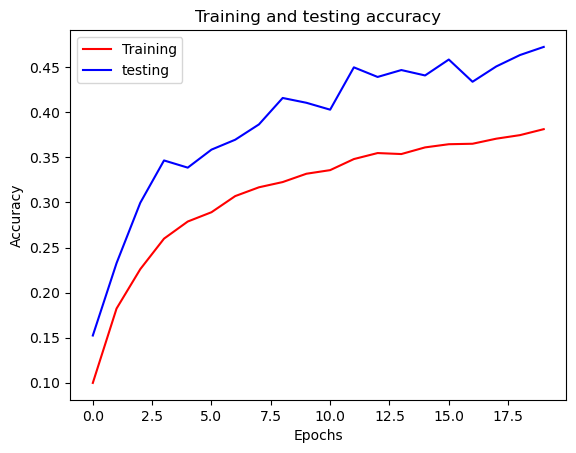

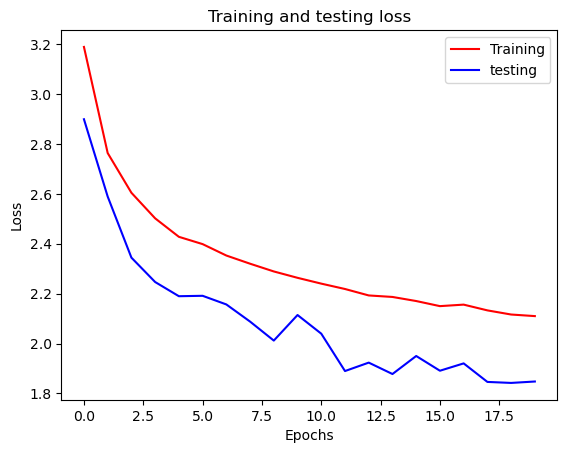

In [11]:
# Dane modelu #16 augmentacja
model_name = 'best_model_nr16'
activation_function = 'relu'
filters_list = [64, 64]
dense_number = 128
dropout_list = [0.35, 0.35]
data = train_generator_aug # train_generator_aug
# Tworzenie modelu
model = create_model_v2(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model2\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model2\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
plot_accuracies(history)

# Testowanie modelu

In [10]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Wczytanie modelu
model = load_model('final_model.h5')

# Testowanie modelu na danych testowych
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Generowanie przewidywań na danych testowych
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Etykiety rzeczywiste
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())  

# Wyświetlanie raportu klasyfikacji
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Wyświetlanie macierzy pomyłek
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print(conf_matrix)


188/188 [==============================] - 83s 441ms/step - loss: 2.2131 - accuracy: 0.5723
Test Loss: 2.2131292819976807
Test Accuracy: 0.5723333358764648
188/188 [==============================] - 80s 424ms/step
               precision    recall  f1-score   support

     aloevera       0.01      0.01      0.01       200
       banana       0.05      0.04      0.05       200
      bilimbi       0.04      0.04      0.04       200
   cantaloupe       0.06      0.05      0.06       200
      cassava       0.04      0.06      0.05       200
      coconut       0.03      0.01      0.02       200
         corn       0.02      0.03      0.02       200
     cucumber       0.05      0.04      0.04       200
      curcuma       0.03      0.04      0.03       200
     eggplant       0.02      0.03      0.02       200
     galangal       0.03      0.04      0.04       200
       ginger       0.06      0.07      0.06       200
        guava       0.05      0.04      0.04       200
         kale  

## Testowanie kolejnych modeli

In [24]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import os

# Function to evaluate a model
def evaluate_model(model_path, test_generator):
    # Load model
    model = load_model(model_path)

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_generator)
    print(f"Model: {model_path}")
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Generate predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Real labels
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())  

    # Classification report
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)
    print(conf_matrix)


architecture1 = os.path.join('models', 'model1')
architecture2 = os.path.join('models', 'model2')

In [16]:
import os
model_path = os.path.join(architecture1, f'best_model_nr1.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 25s 131ms/step - loss: 2.4802 - accuracy: 0.6277
Model: models/model1/best_model_nr1.h5
Test Loss: 2.480153799057007
Test Accuracy: 0.6276666522026062
188/188 [==============================] - 24s 124ms/step
               precision    recall  f1-score   support

     aloevera       0.05      0.04      0.05       200
       banana       0.03      0.03      0.03       200
      bilimbi       0.04      0.04      0.04       200
   cantaloupe       0.04      0.04      0.04       200
      cassava       0.03      0.03      0.03       200
      coconut       0.05      0.03      0.03       200
         corn       0.03      0.03      0.03       200
     cucumber       0.04      0.04      0.04       200
      curcuma       0.03      0.04      0.03       200
     eggplant       0.03      0.04      0.03       200
     galangal       0.04      0.04      0.04       200
       ginger       0.04      0.06      0.05       200
        guava       0.03      0.

In [17]:
import os
model_path = os.path.join(architecture1, f'best_model_nr2.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 25s 129ms/step - loss: 3.4104 - accuracy: 0.0333
Model: models/model1/best_model_nr2.h5
Test Loss: 3.4103941917419434
Test Accuracy: 0.03333333507180214
188/188 [==============================] - 23s 123ms/step
               precision    recall  f1-score   support

     aloevera       0.00      0.00      0.00       200
       banana       0.00      0.00      0.00       200
      bilimbi       0.00      0.00      0.00       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.00      0.00      0.00       200
      coconut       0.00      0.00      0.00       200
         corn       0.00      0.00      0.00       200
     cucumber       0.00      0.00      0.00       200
      curcuma       0.00      0.00      0.00       200
     eggplant       0.00      0.00      0.00       200
     galangal       0.00      0.00      0.00       200
       ginger       0.00      0.00      0.00       200
        guava       0.00      

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
import os
model_path = os.path.join(architecture1, f'best_model_nr3.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 120ms/step - loss: 2.1989 - accuracy: 0.5967
Model: models/model1/best_model_nr3.h5
Test Loss: 2.198867082595825
Test Accuracy: 0.596666693687439
188/188 [==============================] - 22s 118ms/step
               precision    recall  f1-score   support

     aloevera       0.04      0.04      0.04       200
       banana       0.05      0.04      0.04       200
      bilimbi       0.02      0.01      0.02       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.01      0.01      0.01       200
      coconut       0.03      0.01      0.02       200
         corn       0.03      0.04      0.03       200
     cucumber       0.02      0.02      0.02       200
      curcuma       0.02      0.03      0.02       200
     eggplant       0.06      0.04      0.05       200
     galangal       0.03      0.04      0.03       200
       ginger       0.04      0.04      0.04       200
        guava       0.05      0.0

In [19]:
import os
model_path = os.path.join(architecture1, f'best_model_nr4.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 118ms/step - loss: 1.7442 - accuracy: 0.4747
Model: models/model1/best_model_nr4.h5
Test Loss: 1.7442309856414795
Test Accuracy: 0.47466665506362915
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.04      0.01      0.02       200
       banana       0.03      0.03      0.03       200
      bilimbi       0.03      0.02      0.02       200
   cantaloupe       0.02      0.04      0.03       200
      cassava       0.03      0.03      0.03       200
      coconut       0.04      0.04      0.04       200
         corn       0.02      0.03      0.02       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.02      0.03      0.03       200
     eggplant       0.05      0.04      0.05       200
     galangal       0.04      0.04      0.04       200
       ginger       0.03      0.06      0.04       200
        guava       0.03      

In [20]:
import os
model_path = os.path.join(architecture1, f'best_model_nr5.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 117ms/step - loss: 2.1892 - accuracy: 0.5842
Model: models/model1/best_model_nr5.h5
Test Loss: 2.1891677379608154
Test Accuracy: 0.5841666460037231
188/188 [==============================] - 22s 119ms/step
               precision    recall  f1-score   support

     aloevera       0.02      0.01      0.01       200
       banana       0.03      0.02      0.02       200
      bilimbi       0.01      0.01      0.01       200
   cantaloupe       0.02      0.02      0.02       200
      cassava       0.03      0.03      0.03       200
      coconut       0.01      0.01      0.01       200
         corn       0.03      0.04      0.04       200
     cucumber       0.03      0.05      0.04       200
      curcuma       0.02      0.03      0.02       200
     eggplant       0.02      0.02      0.02       200
     galangal       0.04      0.05      0.05       200
       ginger       0.01      0.01      0.01       200
        guava       0.03      0

In [21]:
import os
model_path = os.path.join(architecture1, f'best_model_nr6.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 118ms/step - loss: 2.5125 - accuracy: 0.6333
Model: models/model1/best_model_nr6.h5
Test Loss: 2.512491464614868
Test Accuracy: 0.6333333253860474
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.02      0.01      0.02       200
       banana       0.01      0.01      0.01       200
      bilimbi       0.03      0.04      0.03       200
   cantaloupe       0.01      0.01      0.01       200
      cassava       0.06      0.06      0.06       200
      coconut       0.04      0.03      0.03       200
         corn       0.05      0.09      0.06       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.06      0.06      0.06       200
     eggplant       0.02      0.01      0.02       200
     galangal       0.02      0.02      0.02       200
       ginger       0.06      0.07      0.07       200
        guava       0.02      0.

In [22]:
import os
model_path = os.path.join(architecture1, f'best_model_nr7.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 24s 125ms/step - loss: 4.3591 - accuracy: 0.5842
Model: models/model1/best_model_nr7.h5
Test Loss: 4.359147548675537
Test Accuracy: 0.5841666460037231
188/188 [==============================] - 23s 120ms/step
               precision    recall  f1-score   support

     aloevera       0.03      0.02      0.02       200
       banana       0.03      0.02      0.02       200
      bilimbi       0.03      0.03      0.03       200
   cantaloupe       0.05      0.03      0.03       200
      cassava       0.02      0.03      0.02       200
      coconut       0.04      0.02      0.03       200
         corn       0.05      0.06      0.05       200
     cucumber       0.06      0.04      0.05       200
      curcuma       0.02      0.03      0.03       200
     eggplant       0.02      0.01      0.02       200
     galangal       0.03      0.03      0.03       200
       ginger       0.04      0.05      0.04       200
        guava       0.03      0.

In [23]:
import os
model_path = os.path.join(architecture1, f'best_model_nr8.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 124ms/step - loss: 3.6282 - accuracy: 0.6000
Model: models/model1/best_model_nr8.h5
Test Loss: 3.6282145977020264
Test Accuracy: 0.6000000238418579
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.01      0.01      0.01       200
       banana       0.03      0.01      0.02       200
      bilimbi       0.01      0.01      0.01       200
   cantaloupe       0.02      0.01      0.01       200
      cassava       0.04      0.04      0.04       200
      coconut       0.02      0.01      0.01       200
         corn       0.01      0.01      0.01       200
     cucumber       0.01      0.01      0.01       200
      curcuma       0.00      0.01      0.00       200
     eggplant       0.02      0.03      0.02       200
     galangal       0.03      0.04      0.04       200
       ginger       0.04      0.04      0.04       200
        guava       0.04      0

In [24]:
import os
model_path = os.path.join(architecture1, f'best_model_nr9.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 116ms/step - loss: 2.8760 - accuracy: 0.6015
Model: models/model1/best_model_nr9.h5
Test Loss: 2.8760132789611816
Test Accuracy: 0.6014999747276306
188/188 [==============================] - 22s 117ms/step
               precision    recall  f1-score   support

     aloevera       0.02      0.02      0.02       200
       banana       0.02      0.03      0.02       200
      bilimbi       0.05      0.04      0.04       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.02      0.03      0.03       200
      coconut       0.05      0.03      0.03       200
         corn       0.05      0.06      0.05       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.04      0.04      0.04       200
     eggplant       0.02      0.03      0.03       200
     galangal       0.05      0.06      0.05       200
       ginger       0.03      0.03      0.03       200
        guava       0.05      0

In [25]:
import os
model_path = os.path.join(architecture1, f'best_model_nr10.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 116ms/step - loss: 2.7744 - accuracy: 0.6223
Model: models/model1/best_model_nr10.h5
Test Loss: 2.774421453475952
Test Accuracy: 0.6223333477973938
188/188 [==============================] - 22s 115ms/step
               precision    recall  f1-score   support

     aloevera       0.05      0.04      0.04       200
       banana       0.04      0.04      0.04       200
      bilimbi       0.02      0.03      0.02       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.06      0.05      0.06       200
      coconut       0.05      0.03      0.04       200
         corn       0.06      0.10      0.08       200
     cucumber       0.04      0.04      0.04       200
      curcuma       0.05      0.06      0.05       200
     eggplant       0.01      0.01      0.01       200
     galangal       0.02      0.03      0.02       200
       ginger       0.05      0.05      0.05       200
        guava       0.07      0

In [26]:
import os
model_path = os.path.join(architecture1, f'best_model_nr11.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 22s 116ms/step - loss: 1.9650 - accuracy: 0.6387
Model: models/model1/best_model_nr11.h5
Test Loss: 1.9650059938430786
Test Accuracy: 0.6386666893959045
188/188 [==============================] - 22s 116ms/step
               precision    recall  f1-score   support

     aloevera       0.06      0.05      0.06       200
       banana       0.03      0.03      0.03       200
      bilimbi       0.05      0.06      0.05       200
   cantaloupe       0.03      0.04      0.04       200
      cassava       0.03      0.03      0.03       200
      coconut       0.02      0.01      0.01       200
         corn       0.04      0.04      0.04       200
     cucumber       0.03      0.04      0.03       200
      curcuma       0.05      0.06      0.05       200
     eggplant       0.02      0.03      0.03       200
     galangal       0.01      0.01      0.01       200
       ginger       0.03      0.03      0.03       200
        guava       0.02      

In [27]:
import os
model_path = os.path.join(architecture1, f'best_model_nr12.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 119ms/step - loss: 3.4012 - accuracy: 0.0333
Model: models/model1/best_model_nr12.h5
Test Loss: 3.4012160301208496
Test Accuracy: 0.03333333507180214
188/188 [==============================] - 21s 113ms/step
               precision    recall  f1-score   support

     aloevera       0.00      0.00      0.00       200
       banana       0.00      0.00      0.00       200
      bilimbi       0.00      0.00      0.00       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.03      1.00      0.06       200
      coconut       0.00      0.00      0.00       200
         corn       0.00      0.00      0.00       200
     cucumber       0.00      0.00      0.00       200
      curcuma       0.00      0.00      0.00       200
     eggplant       0.00      0.00      0.00       200
     galangal       0.00      0.00      0.00       200
       ginger       0.00      0.00      0.00       200
        guava       0.00     

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
import os
model_path = os.path.join(architecture2, f'best_model_nr13.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 24s 126ms/step - loss: 2.5977 - accuracy: 0.6053
Model: models/model2/best_model_nr13.h5
Test Loss: 2.597714424133301
Test Accuracy: 0.6053333282470703
188/188 [==============================] - 23s 123ms/step
               precision    recall  f1-score   support

     aloevera       0.03      0.02      0.02       200
       banana       0.03      0.02      0.03       200
      bilimbi       0.02      0.03      0.02       200
   cantaloupe       0.02      0.02      0.02       200
      cassava       0.07      0.07      0.07       200
      coconut       0.04      0.02      0.03       200
         corn       0.02      0.02      0.02       200
     cucumber       0.04      0.04      0.04       200
      curcuma       0.05      0.07      0.05       200
     eggplant       0.03      0.03      0.03       200
     galangal       0.03      0.03      0.03       200
       ginger       0.02      0.03      0.03       200
        guava       0.07      0

In [29]:
import os
model_path = os.path.join(architecture2, f'best_model_nr14.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 123ms/step - loss: 3.4089 - accuracy: 0.0333
Model: models/model2/best_model_nr14.h5
Test Loss: 3.408933162689209
Test Accuracy: 0.03333333507180214
188/188 [==============================] - 23s 122ms/step
               precision    recall  f1-score   support

     aloevera       0.00      0.00      0.00       200
       banana       0.00      0.00      0.00       200
      bilimbi       0.00      0.00      0.00       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.00      0.00      0.00       200
      coconut       0.00      0.00      0.00       200
         corn       0.00      0.00      0.00       200
     cucumber       0.00      0.00      0.00       200
      curcuma       0.00      0.00      0.00       200
     eggplant       0.00      0.00      0.00       200
     galangal       0.00      0.00      0.00       200
       ginger       0.00      0.00      0.00       200
        guava       0.00      

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
import os
model_path = os.path.join(architecture2, f'best_model_nr15.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 122ms/step - loss: 2.8158 - accuracy: 0.1693
Model: models/model2/best_model_nr15.h5
Test Loss: 2.815804958343506
Test Accuracy: 0.1693333387374878
188/188 [==============================] - 23s 121ms/step
               precision    recall  f1-score   support

     aloevera       0.07      0.03      0.04       200
       banana       0.02      0.03      0.03       200
      bilimbi       0.03      0.04      0.03       200
   cantaloupe       0.00      0.00      0.00       200
      cassava       0.03      0.10      0.05       200
      coconut       0.04      0.01      0.02       200
         corn       0.03      0.15      0.06       200
     cucumber       0.03      0.01      0.01       200
      curcuma       0.02      0.01      0.01       200
     eggplant       0.02      0.01      0.01       200
     galangal       0.02      0.02      0.02       200
       ginger       0.03      0.11      0.05       200
        guava       0.00      0

/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pawel/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
import os
model_path = os.path.join(architecture2, f'best_model_nr16.h5')
evaluate_model(model_path, test_generator)

188/188 [==============================] - 23s 120ms/step - loss: 1.9413 - accuracy: 0.4415
Model: models/model2/best_model_nr16.h5
Test Loss: 1.9413349628448486
Test Accuracy: 0.4415000081062317
188/188 [==============================] - 22s 118ms/step
               precision    recall  f1-score   support

     aloevera       0.03      0.02      0.02       200
       banana       0.03      0.01      0.02       200
      bilimbi       0.02      0.01      0.01       200
   cantaloupe       0.02      0.01      0.01       200
      cassava       0.04      0.07      0.05       200
      coconut       0.04      0.07      0.05       200
         corn       0.03      0.03      0.03       200
     cucumber       0.03      0.03      0.03       200
      curcuma       0.04      0.06      0.04       200
     eggplant       0.02      0.03      0.02       200
     galangal       0.06      0.07      0.06       200
       ginger       0.04      0.06      0.05       200
        guava       0.02      

# Uczenie kolejnych modeli

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 26, 26, 64)       

/home/paul/Coding/Studies/P-Sieci-Neuronowe/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 116s 176ms/step - loss: 2.7649 - accuracy: 0.1829 - val_loss: 2.5274 - val_accuracy: 0.2460
Epoch 3/20
657/657 [==============================] - 115s 175ms/step - loss: 2.6609 - accuracy: 0.2120 - val_loss: 2.3999 - val_accuracy: 0.2723
Epoch 4/20
657/657 [==============================] - 112s 170ms/step - loss: 2.5766 - accuracy: 0.2402 - val_loss: 2.3434 - val_accuracy: 0.3250
Epoch 5/20
657/657 [==============================] - 111s 169ms/step - loss: 2.5249 - accuracy: 0.2499 - val_loss: 2.2426 - val_accuracy: 0.3357
Epoch 6/20
657/657 [==============================] - 112s 171ms/step - loss: 2.4677 - accuracy: 0.2620 - val_loss: 2.3332 - val_accuracy: 0.3120
Epoch 7/20
657/657 [==============================] - 111s 169ms/step - loss: 2.4373 - accuracy: 0.2756 - val_loss: 2.2188 - val_accuracy: 0.3347
Epoch 8/20
657/657 [==============================] - 112s 170ms/step - loss: 2.3991 - accuracy: 0.2862 - val_loss: 2.1266 - val_accura

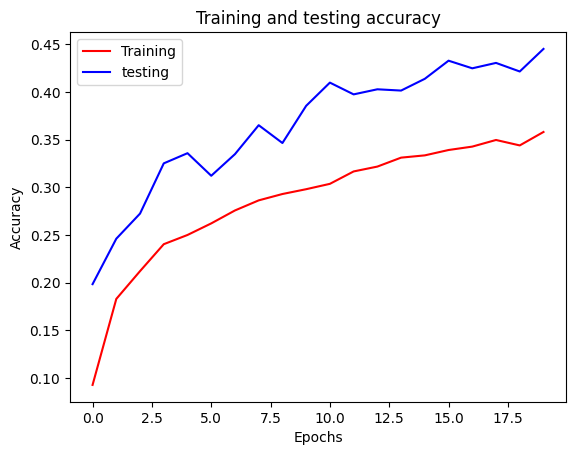

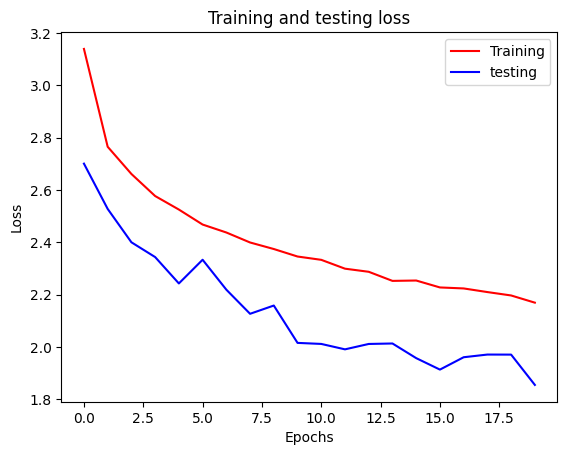

In [19]:
# Dane modelu #17, model 11 z augmentacja
model_name = 'best_model_nr17'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator_aug
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 111, 111, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 26, 26, 64)       

/home/paul/Coding/Studies/P-Sieci-Neuronowe/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 126s 192ms/step - loss: 2.6683 - accuracy: 0.2058 - val_loss: 2.5025 - val_accuracy: 0.2600
Epoch 3/20
657/657 [==============================] - 127s 193ms/step - loss: 2.5531 - accuracy: 0.2403 - val_loss: 2.2697 - val_accuracy: 0.3410
Epoch 4/20
657/657 [==============================] - 127s 193ms/step - loss: 2.4588 - accuracy: 0.2646 - val_loss: 2.2128 - val_accuracy: 0.3587
Epoch 5/20
657/657 [==============================] - 126s 191ms/step - loss: 2.4101 - accuracy: 0.2852 - val_loss: 2.2190 - val_accuracy: 0.3520
Epoch 6/20
657/657 [==============================] - 123s 187ms/step - loss: 2.3486 - accuracy: 0.2962 - val_loss: 2.1178 - val_accuracy: 0.3800
Epoch 7/20
657/657 [==============================] - 123s 187ms/step - loss: 2.3038 - accuracy: 0.3143 - val_loss: 2.0494 - val_accuracy: 0.4017
Epoch 8/20
657/657 [==============================] - 124s 188ms/step - loss: 2.2593 - accuracy: 0.3310 - val_loss: 1.9905 - val_accura

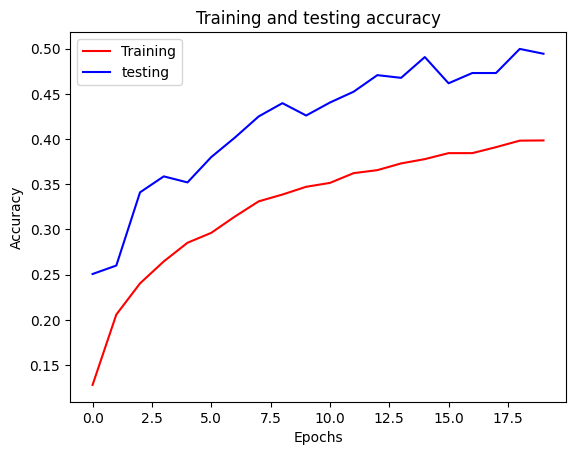

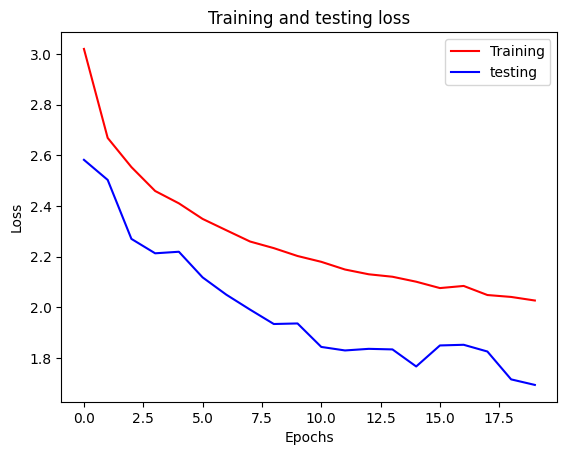

In [21]:
# Dane modelu #11 z inna augmentacja
model_name = 'best_model_nr18'
activation_function = 'relu'
filters_list = [64, 64, 64]
dense_number = 128
dropout_list = [0.5, 0.5]
data = train_generator_aug2
# Tworzenie modelu
model = create_model_v1(activation_function, filters_list, dense_number, dropout_list)
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"model1\\{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model_v3(activation_function='relu', filters_list=[32, 64, 128], dense_number=256, dropout_list=[0.25, 0.5]):
    model = Sequential()
   
    model.add(Conv2D(filters_list[0], (3, 3), padding='same', activation=activation_function, input_shape=(224, 224, 3)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(dropout_list[0]))

    for filters in filters_list[1:]:
        model.add(Conv2D(filters, (3, 3), padding='same', activation=activation_function))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))

        if len(dropout_list) > 1:
            model.add(Dropout(dropout_list[1]))

    model.add(Flatten())
    model.add(Dense(dense_number, activation=activation_function))
    model.add(BatchNormalization())

    model.add(Dropout(dropout_list[-1]))
    model.add(Dense(30, activation='softmax'))
    
    return model


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_20 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_21 (Ba  (None, 112, 112, 64)     

/home/paul/Coding/Studies/P-Sieci-Neuronowe/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
657/657 [==============================] - 60s 91ms/step - loss: 2.1569 - accuracy: 0.3695 - val_loss: 8.5669 - val_accuracy: 0.2883
Epoch 3/20
657/657 [==============================] - 60s 91ms/step - loss: 1.7395 - accuracy: 0.4856 - val_loss: 2.8632 - val_accuracy: 0.4720
Epoch 4/20
657/657 [==============================] - 59s 90ms/step - loss: 1.4058 - accuracy: 0.5851 - val_loss: 3.5691 - val_accuracy: 0.4497
Epoch 5/20
657/657 [==============================] - 60s 91ms/step - loss: 1.0164 - accuracy: 0.6875 - val_loss: 2.6156 - val_accuracy: 0.5860
Epoch 6/20
657/657 [==============================] - 59s 90ms/step - loss: 0.7213 - accuracy: 0.7699 - val_loss: 1.4567 - val_accuracy: 0.6340
Epoch 7/20
657/657 [==============================] - 62s 94ms/step - loss: 0.6216 - accuracy: 0.7977 - val_loss: 1.2170 - val_accuracy: 0.6957
Epoch 8/20
657/657 [==============================] - 59s 90ms/step - loss: 0.4482 - accuracy: 0.8488 - val_loss: 1.3037 - val_accuracy:

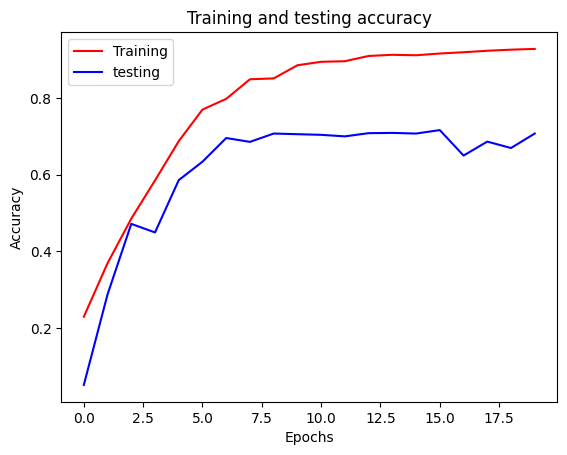

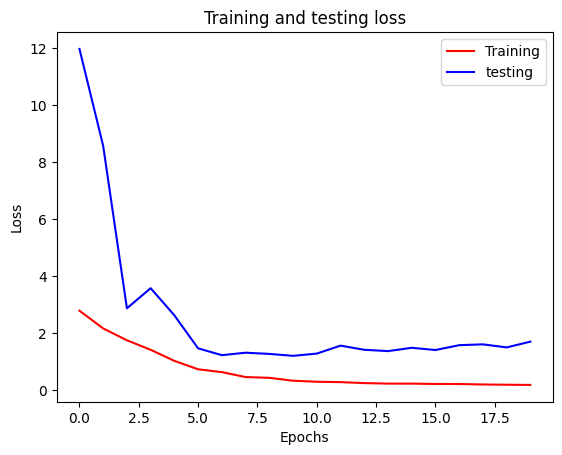

In [45]:
# model 19, nowa architektura
model_name = 'best_model_nr19'
data = train_generator
# Tworzenie modelu
model = create_model_v3()
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=20, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_24 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_28 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_25 (Ba  (None, 112, 112, 64)     

2024-01-21 21:27:58.506028: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


657/657 [==============================] - 125s 189ms/step - loss: 3.0259 - accuracy: 0.1733 - val_loss: 11.2771 - val_accuracy: 0.1257
Epoch 2/40
657/657 [==============================] - 124s 189ms/step - loss: 2.5257 - accuracy: 0.2607 - val_loss: 6.7678 - val_accuracy: 0.1813
Epoch 3/40
657/657 [==============================] - 124s 189ms/step - loss: 2.2925 - accuracy: 0.3200 - val_loss: 2.5311 - val_accuracy: 0.3323
Epoch 4/40
657/657 [==============================] - 124s 189ms/step - loss: 2.1649 - accuracy: 0.3598 - val_loss: 2.6655 - val_accuracy: 0.3980
Epoch 5/40
657/657 [==============================] - 124s 189ms/step - loss: 2.0537 - accuracy: 0.3939 - val_loss: 2.2901 - val_accuracy: 0.4430
Epoch 6/40
657/657 [==============================] - 128s 194ms/step - loss: 1.9827 - accuracy: 0.4136 - val_loss: 1.8628 - val_accuracy: 0.4527
Epoch 7/40
657/657 [==============================] - 127s 193ms/step - loss: 1.9095 - accuracy: 0.4356 - val_loss: 1.9261 - val_accur

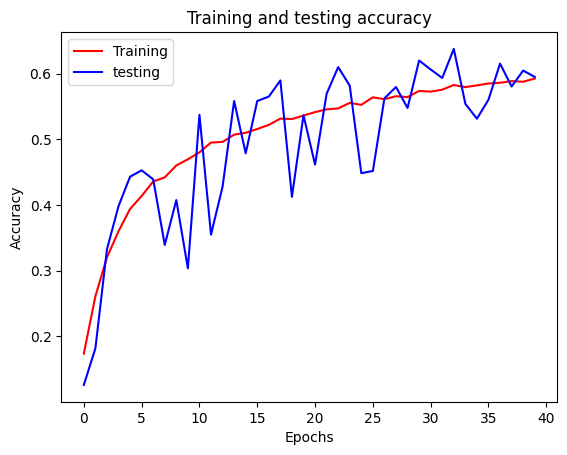

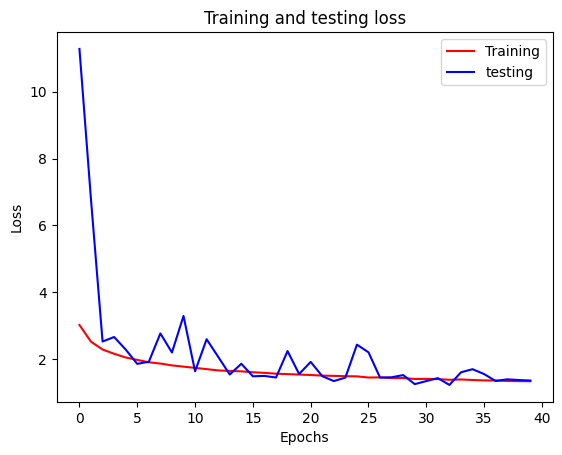

In [46]:
# model 20, augmentacja
model_name = 'best_model_nr20'
data = train_generator_aug2
# Tworzenie modelu
model = create_model_v3()
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=40, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

In [42]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

def evaluate_model(model_path, test_generator):
    """
    Evaluates the given model using the provided test data generator.

    Args:
    - model_path (str): Path to the saved model.
    - test_generator (ImageDataGenerator): Test data generator.

    Returns:
    - None; prints out the model's loss, accuracy, and classification report.
    """

    # Load the model
    model = load_model(model_path)

    # Evaluate the model
    eval_results = model.evaluate(test_generator)
    print(f"Test Loss: {eval_results[0]}")
    print(f"Test Accuracy: {eval_results[1]}")

    # Predict the labels for test data
    test_generator.reset()  # Reset the generator to ensure the order
    predictions = model.predict(test_generator, steps=np.ceil(test_generator.samples / test_generator.batch_size))

    # Convert the predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1)

    # Handle the mismatch in sample count if the test set size isn't divisible by the batch size
    num_samples = test_generator.samples
    true_classes = test_generator.classes[:num_samples]
    predicted_classes = predicted_classes[:num_samples]

    # Calculate and print the classification report
    class_labels = list(test_generator.class_indices.keys())
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(report)

    # Calculate and print the overall accuracy
    accuracy = accuracy_score(true_classes, predicted_classes)
    print(f"Overall Accuracy: {accuracy}")


In [43]:
evaluate_model("best_model_nr11.h5", test_generator)

188/188 [==============================] - 7s 34ms/step - loss: 1.3919 - accuracy: 0.5925
Test Loss: 1.3919342756271362
Test Accuracy: 0.5924999713897705
188/188 [==============================] - 6s 34ms/step
               precision    recall  f1-score   support

     aloevera       0.53      0.58      0.56       200
       banana       0.45      0.36      0.40       200
      bilimbi       0.39      0.32      0.35       200
   cantaloupe       0.47      0.63      0.54       200
      cassava       0.46      0.65      0.53       200
      coconut       0.53      0.35      0.43       200
         corn       0.65      0.75      0.69       200
     cucumber       0.90      0.55      0.68       200
      curcuma       0.55      0.70      0.62       200
     eggplant       0.78      0.61      0.69       200
     galangal       0.54      0.74      0.62       200
       ginger       0.62      0.34      0.44       200
        guava       0.74      0.68      0.70       200
         kale      

In [48]:
evaluate_model("best_model_nr19.h5", test_generator)

188/188 [==============================] - 6s 34ms/step - loss: 1.6812 - accuracy: 0.6647
Test Loss: 1.6811622381210327
Test Accuracy: 0.6646666526794434
188/188 [==============================] - 6s 33ms/step
               precision    recall  f1-score   support

     aloevera       0.78      0.70      0.74       200
       banana       0.70      0.34      0.46       200
      bilimbi       0.68      0.57      0.62       200
   cantaloupe       0.28      0.09      0.13       200
      cassava       0.63      0.68      0.65       200
      coconut       0.55      0.33      0.41       200
         corn       0.72      0.82      0.77       200
     cucumber       0.70      0.79      0.74       200
      curcuma       0.64      0.83      0.72       200
     eggplant       0.65      0.73      0.69       200
     galangal       0.75      0.81      0.78       200
       ginger       0.54      0.65      0.59       200
        guava       0.79      0.66      0.72       200
         kale      

In [49]:
evaluate_model("best_model_nr20.h5", test_generator)

188/188 [==============================] - 6s 33ms/step - loss: 1.3063 - accuracy: 0.6210
Test Loss: 1.3062533140182495
Test Accuracy: 0.6209999918937683
188/188 [==============================] - 6s 32ms/step
               precision    recall  f1-score   support

     aloevera       0.80      0.54      0.64       200
       banana       0.38      0.50      0.43       200
      bilimbi       0.38      0.42      0.40       200
   cantaloupe       0.33      0.03      0.06       200
      cassava       0.44      0.71      0.55       200
      coconut       0.43      0.36      0.39       200
         corn       0.75      0.73      0.74       200
     cucumber       0.95      0.60      0.74       200
      curcuma       0.57      0.67      0.62       200
     eggplant       0.79      0.71      0.75       200
     galangal       0.56      0.80      0.66       200
       ginger       0.58      0.52      0.54       200
        guava       0.79      0.63      0.70       200
         kale      

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_28 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_30 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_31 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_29 (Ba  (None, 112, 112, 64)    

2024-01-21 22:54:18.692034: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_10/dropout_32/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


657/657 [==============================] - 62s 92ms/step - loss: 2.8918 - accuracy: 0.2078 - val_loss: 5.7807 - val_accuracy: 0.1543
Epoch 2/40


/home/paul/Coding/Studies/P-Sieci-Neuronowe/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


657/657 [==============================] - 60s 91ms/step - loss: 2.2773 - accuracy: 0.3396 - val_loss: 2.2424 - val_accuracy: 0.3703
Epoch 3/40
657/657 [==============================] - 59s 89ms/step - loss: 1.8621 - accuracy: 0.4505 - val_loss: 2.4774 - val_accuracy: 0.3633
Epoch 4/40
657/657 [==============================] - 59s 90ms/step - loss: 1.6013 - accuracy: 0.5229 - val_loss: 1.6189 - val_accuracy: 0.5340
Epoch 5/40
657/657 [==============================] - 59s 90ms/step - loss: 1.2196 - accuracy: 0.6278 - val_loss: 1.3180 - val_accuracy: 0.6380
Epoch 6/40
657/657 [==============================] - 59s 89ms/step - loss: 0.8667 - accuracy: 0.7312 - val_loss: 1.3545 - val_accuracy: 0.6277
Epoch 7/40
657/657 [==============================] - 59s 90ms/step - loss: 0.6372 - accuracy: 0.7901 - val_loss: 1.3805 - val_accuracy: 0.6683
Epoch 8/40
657/657 [==============================] - 59s 90ms/step - loss: 0.4873 - accuracy: 0.8352 - val_loss: 1.1996 - val_accuracy: 0.6963
Epo

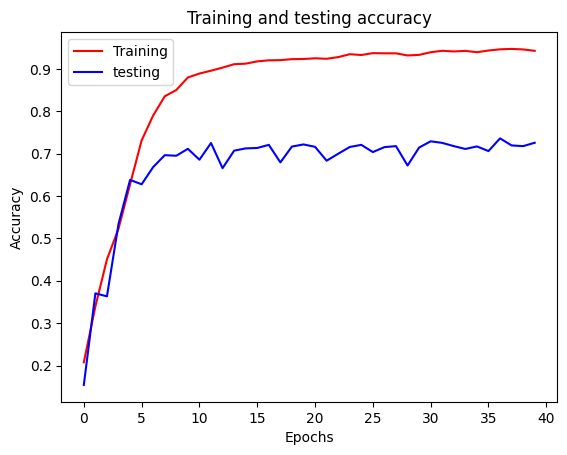

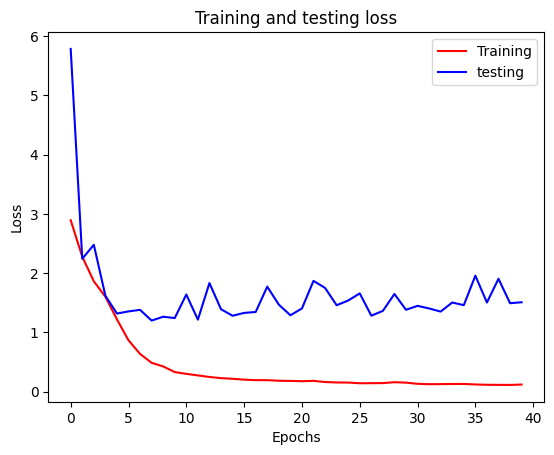

In [50]:
# model 21, 19 - ale wiecej epok
model_name = 'best_model_nr21'
data = train_generator
# Tworzenie modelu
model = create_model_v3()
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# Callback do zapisywania najlepszego modelu
checkpoint = ModelCheckpoint(f"{model_name}.h5", monitor='val_accuracy', save_best_only=True, mode='max')
# Trenowanie modelu
history = model.fit(
    data,
    epochs=40, 
    validation_data=validation_generator,
    callbacks=[checkpoint],
    batch_size = 8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

In [51]:
evaluate_model("best_model_nr21.h5", test_generator)

188/188 [==============================] - 6s 34ms/step - loss: 1.7854 - accuracy: 0.6837
Test Loss: 1.7853525876998901
Test Accuracy: 0.6836666464805603
188/188 [==============================] - 6s 33ms/step
               precision    recall  f1-score   support

     aloevera       0.78      0.67      0.72       200
       banana       0.69      0.39      0.49       200
      bilimbi       0.61      0.58      0.60       200
   cantaloupe       0.27      0.12      0.16       200
      cassava       0.72      0.66      0.69       200
      coconut       0.70      0.33      0.45       200
         corn       0.67      0.80      0.73       200
     cucumber       0.60      0.79      0.68       200
      curcuma       0.70      0.82      0.75       200
     eggplant       0.78      0.73      0.75       200
     galangal       0.65      0.88      0.75       200
       ginger       0.65      0.71      0.68       200
        guava       0.82      0.70      0.76       200
         kale      

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Monitor validation accuracy
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restores model weights from the epoch with the highest validation accuracy
)


In [55]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Metric to monitor
    factor=0.2,          # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=2,          # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=0.00001       # Lower bound on the learning rate
)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_32 (Ba  (None, 224, 224, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 112, 112, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 112, 112, 32)      0         
                                                                 
 conv2d_34 (Conv2D)          (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_33 (Ba  (None, 112, 112, 64)    

2024-01-21 23:40:09.861016: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_36/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


657/657 [==============================] - 62s 93ms/step - loss: 2.7756 - accuracy: 0.2299 - val_loss: 5.4051 - val_accuracy: 0.2007 - lr: 0.0010
Epoch 2/40
657/657 [==============================] - 62s 94ms/step - loss: 2.0939 - accuracy: 0.3885 - val_loss: 117.6176 - val_accuracy: 0.1487 - lr: 0.0010
Epoch 3/40
657/657 [==============================] - 63s 96ms/step - loss: 1.6589 - accuracy: 0.5114 - val_loss: 2.2250 - val_accuracy: 0.5363 - lr: 0.0010
Epoch 4/40
657/657 [==============================] - 61s 93ms/step - loss: 1.2157 - accuracy: 0.6354 - val_loss: 4.8612 - val_accuracy: 0.4767 - lr: 0.0010
Epoch 5/40
657/657 [==============================] - 63s 95ms/step - loss: 0.8824 - accuracy: 0.7251 - val_loss: 5.4285 - val_accuracy: 0.5410 - lr: 0.0010
Epoch 6/40
657/657 [==============================] - 59s 90ms/step - loss: 0.5101 - accuracy: 0.8352 - val_loss: 1.6835 - val_accuracy: 0.6760 - lr: 2.0000e-04
Epoch 7/40
657/657 [==============================] - 61s 92ms/

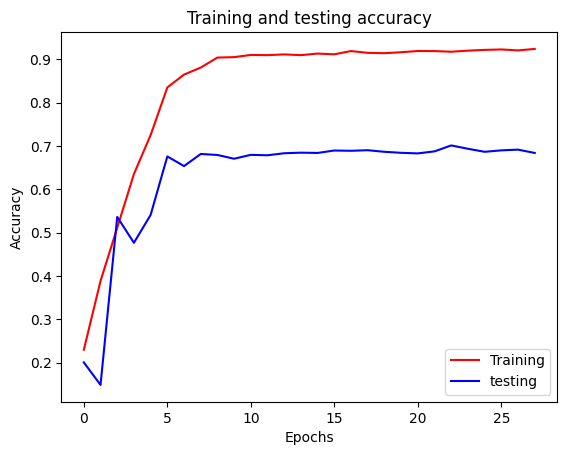

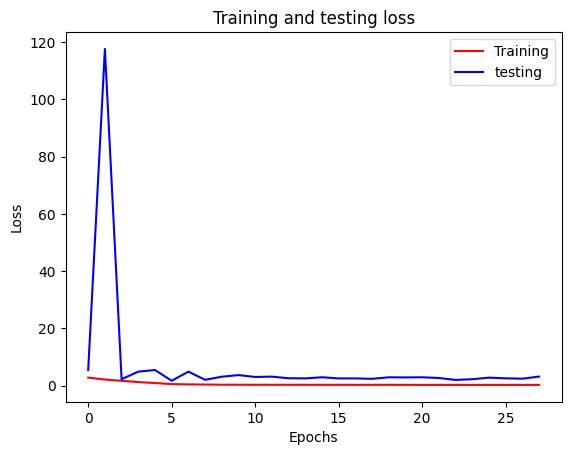

In [56]:


# Rest of your code remains the same
# model 21, 19 - ale wiecej epok
model_name = 'best_model_nr22'
data = train_generator
# Tworzenie modelu
model = create_model_v3()
# Podsumowanie modelu
model.summary()
# Kompilacja modelu
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Include both callbacks
callbacks = [checkpoint, early_stopping, reduce_lr]

history = model.fit(
    data,
    epochs=40,
    validation_data=validation_generator,
    callbacks=callbacks,
    batch_size=8
)
# Zapisz historię
with open(f"model1\\{model_name}_history.pkl", 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
# Wyświetl dane
print(history.params)
plot_accuracies(history)

In [57]:
evaluate_model("best_model_nr21.h5", test_generator)

188/188 [==============================] - 6s 33ms/step - loss: 1.7854 - accuracy: 0.6837
Test Loss: 1.7853525876998901
Test Accuracy: 0.6836666464805603
188/188 [==============================] - 6s 33ms/step
               precision    recall  f1-score   support

     aloevera       0.78      0.67      0.72       200
       banana       0.69      0.39      0.49       200
      bilimbi       0.61      0.58      0.60       200
   cantaloupe       0.27      0.12      0.16       200
      cassava       0.72      0.66      0.69       200
      coconut       0.70      0.33      0.45       200
         corn       0.67      0.80      0.73       200
     cucumber       0.60      0.79      0.68       200
      curcuma       0.70      0.82      0.75       200
     eggplant       0.78      0.73      0.75       200
     galangal       0.65      0.88      0.75       200
       ginger       0.65      0.71      0.68       200
        guava       0.82      0.70      0.76       200
         kale      